# Predicting Heart Disease

## Importing Libraries

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin


from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score, ConfusionMatrixDisplay, confusion_matrix

import tensorflow as tf
from tensorflow import keras

2024-04-24 10:23:42.466565: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 10:23:45.377582: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Loading Data

In [64]:
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Understanding Data

In [65]:
df.shape

(918, 12)

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


There are 918 values in each column and shape of df is also 918. So there are no missing values.

Next we can see that columns `Sex`, `ChestPainType`, `RestingECG`, `ExerciseAngina` and `ST_Slope` are having `object` datatypes, that means they are categorical attributes and thus we need to encode them using `OneHotEncoder`.

Let's try to find out uniques values for these `object` datatypes.

In [67]:
df["Sex"].value_counts()

M    725
F    193
Name: Sex, dtype: int64

In [68]:
df["ChestPainType"].value_counts()

ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64

In [69]:
df["RestingECG"].value_counts()

Normal    552
LVH       188
ST        178
Name: RestingECG, dtype: int64

In [70]:
df["ExerciseAngina"].value_counts()

N    547
Y    371
Name: ExerciseAngina, dtype: int64

In [71]:
df["ST_Slope"].value_counts()

Flat    460
Up      395
Down     63
Name: ST_Slope, dtype: int64

### Here's what each column means

- ChestPainType : TA = Typical Angina, ATA = Atypical Angina, NAP = Non-Anginal Pain, ASY = Asymptomatic
  - TA means chest pain related decrease blood supply to the heart
  - ATA means chest pain not related to heart
  - NAP means not related to heart issues
  - ASY means no chest pain

- restingbp: mm Hg (unit)
- cholesterol: mg/dl (unit)
- fastingBs: (1 = fasting blood sugar is greater than 120 mg/dl, 0 = otherwise).
- RestingECG: Resting electrocardiographic results
  - Normal = normal
  - ST = having ST-T wave abnormality
  - LVH = showing probable or definite left ventricular hypertrophy
- MaxHR: max heart rate achieved
- ExerciseAngina: (Y = yes; N = no): Exercise-induced angina (chest pain). This is chest pain due to lack of blood supply to the heart due to physical activity.
- Oldpeak: ST depression induced by exercise relative to rest [Numeric value measured in depression]
- ST_Slope = slope of peak exercise ST Segment [Up: upslopping, Flat: flat, Down: downslopping]
- HearDisease = output class [1: heart disease, 0: Normal]

## Some Statistics about Data

In [72]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


### Plotting Histogram

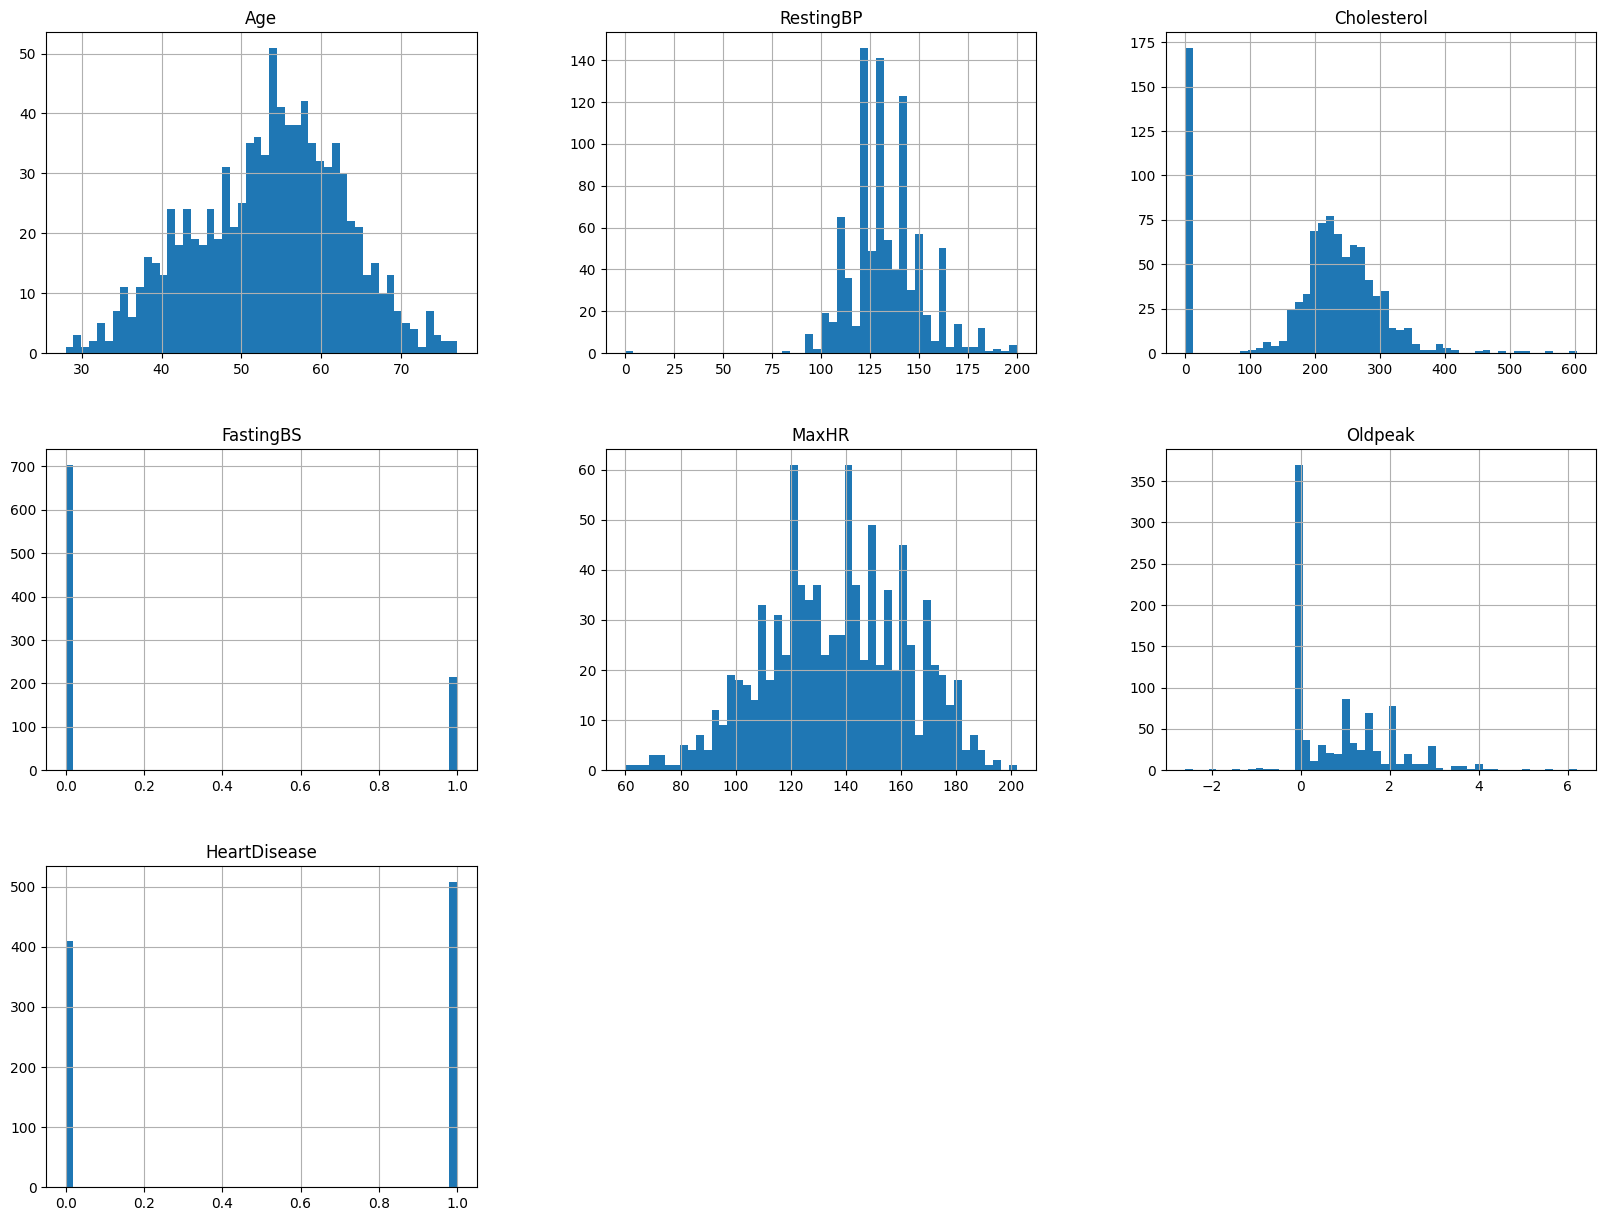

In [73]:
df.hist(bins=50, figsize=(20, 15))
plt.show()

## Splitting Data into Train and Test Set

In [74]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [75]:
train_set.shape, test_set.shape

((734, 12), (184, 12))

In [76]:
train_set.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
795,42,M,NAP,120,240,1,Normal,194,N,0.8,Down,0
25,36,M,NAP,130,209,0,Normal,178,N,0.0,Up,0
84,56,M,ASY,150,213,1,Normal,125,Y,1.0,Flat,1
10,37,F,NAP,130,211,0,Normal,142,N,0.0,Up,0
344,51,M,ASY,120,0,1,Normal,104,N,0.0,Flat,1


## Digging Further into EDA

### Correlation Matrix

In [77]:
corr_mat = train_set.corr(numeric_only=True)
corr_mat

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
Age,1.000000,0.282245,-0.102452,0.213311,-0.386743,0.288749,0.299410
RestingBP,0.282245,1.000000,0.072624,0.079418,-0.137316,0.173900,0.138611
Cholesterol,-0.102452,0.072624,1.000000,-0.272745,0.248506,0.049840,-0.251893
FastingBS,0.213311,0.079418,-0.272745,1.000000,-0.141972,0.042815,0.259565
MaxHR,-0.386743,-0.137316,0.248506,-0.141972,1.000000,-0.174141,-0.414676
Oldpeak,0.288749,0.173900,0.049840,0.042815,-0.174141,1.000000,0.422740
HeartDisease,0.299410,0.138611,-0.251893,0.259565,-0.414676,0.422740,1.000000


### Scatter Matrix

We can also plot scatter matrix to see the relationship between different attributes.

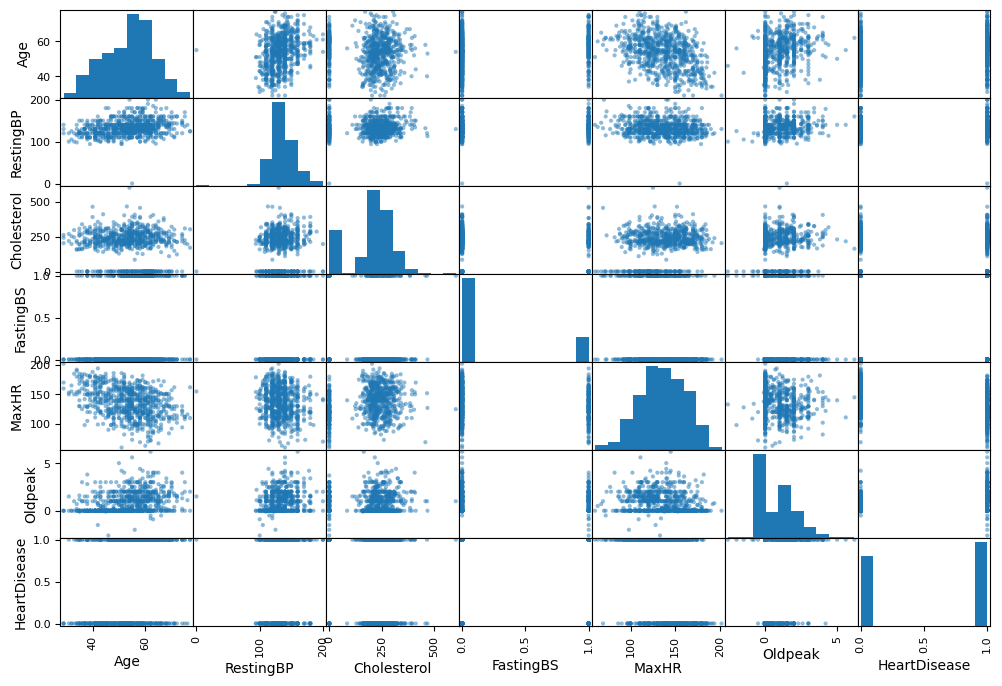

In [78]:
pd.plotting.scatter_matrix(train_set, figsize=(12, 8))
plt.show()

### Heatmap

Plotting heatmap to see correlation between different attributes more clearly.

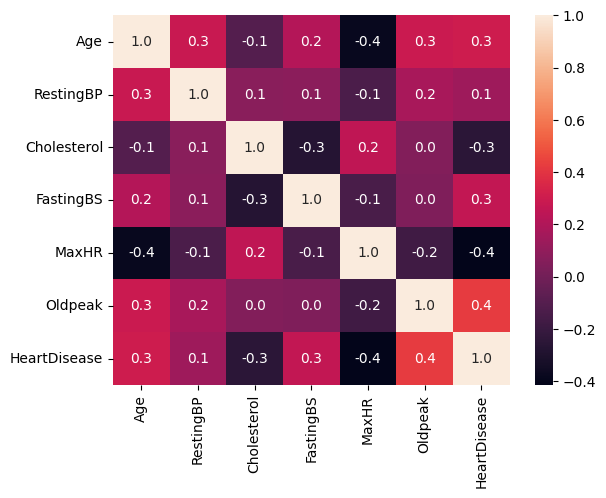

In [79]:
sns.heatmap(corr_mat, annot=True, fmt=".1f")
plt.show()

RestingBP is not much correlated to output varibale.

TODO: later try removing this variabe and train the whole model again. For trying various combinations it will be best to create and use pipelines.

We are more interested in how our target variable i.e., HeartDisease is related to to every other features.

In [80]:
corr_mat["HeartDisease"].sort_values(ascending=False)

HeartDisease    1.000000
Oldpeak         0.422740
Age             0.299410
FastingBS       0.259565
RestingBP       0.138611
Cholesterol    -0.251893
MaxHR          -0.414676
Name: HeartDisease, dtype: float64

Oldpeak and MaxHr seems to be correlated to output variable. They are not much correlated but compared to other features they are more correlated.

Oldpeak is positively correlated to HeartDisease and MaxHR is negatively correlated to HeartDisease. This negative correlation also satifies the fact that as the heart rate increases the chances of heart disease decreases.

MaxHR is also highly correlated (negatively) to Age which justifies the fact that as the age increases the heart rate decreases.

Let's count the percentage of people having heart disease and not having heart disease. This will give us an idea about the distribution of output variable.

In [81]:
# count of patients with heart disease
train_set["HeartDisease"].value_counts() / len(train_set) * 100

1    54.632153
0    45.367847
Name: HeartDisease, dtype: float64

Our dataset contains 54% of heart disease cases and 46% of normal cases. So it is a balanced dataset.

In [82]:
train_set.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
795,42,M,NAP,120,240,1,Normal,194,N,0.8,Down,0
25,36,M,NAP,130,209,0,Normal,178,N,0.0,Up,0
84,56,M,ASY,150,213,1,Normal,125,Y,1.0,Flat,1
10,37,F,NAP,130,211,0,Normal,142,N,0.0,Up,0
344,51,M,ASY,120,0,1,Normal,104,N,0.0,Flat,1


### Exploring every feature

#### Age

Let's start with `Age` feature and plot histogram to see the distribution of age.

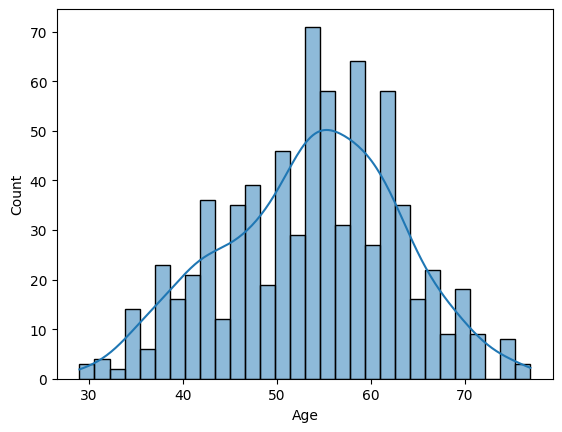

In [83]:
sns.histplot(train_set, x="Age", bins=30, kde=True)
plt.show()

Now let's bifercate the age into different age groups and see the distribution of heart disease in each age group.

In [84]:
train_set["Age"].min(), train_set["Age"].max()

(29, 77)

Age is starting from 29 and ending at 77. We can create 3 age groups: 20-39, 40-59, 60-80. We'll name them as Young, Middle and Old.

In [85]:
# it's better to copy the training set to avoid any changes to the original data
train_set1 = train_set.copy()

In [86]:
train_set1["Age_Cat"] = pd.cut(train_set1["Age"], bins=[20, 40,  60, 80], labels=["Young", "Middle", "Old"], right=False) # right=False means that the interval is left-closed, right-open, i.e., does not include the rightmost value

In [87]:
train_set1["Age_Cat"].value_counts()

Middle    468
Old       205
Young      61
Name: Age_Cat, dtype: int64

Let's plot the age groups and see the distribution of heart disease in each age group.

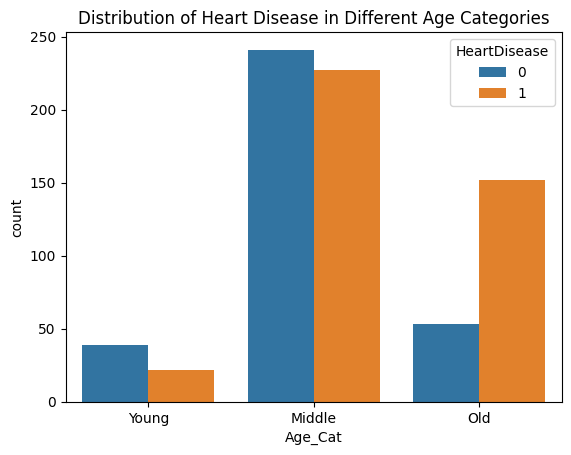

In [88]:
sns.countplot(data=train_set1, x="Age_Cat", hue="HeartDisease")
plt.title("Distribution of Heart Disease in Different Age Categories")
plt.show()

We can see that heart disease is more in Middle age group but number of normal cases are also more in Middle age group. So we can't say that Middle age group is more prone to heart disease. Whereas in Old age group, heart disease cases are more as compared to normal cases. So we can say that Old age group is more prone to heart disease.

#### Gender

Let's plot the distribution of heart disease in each gender.

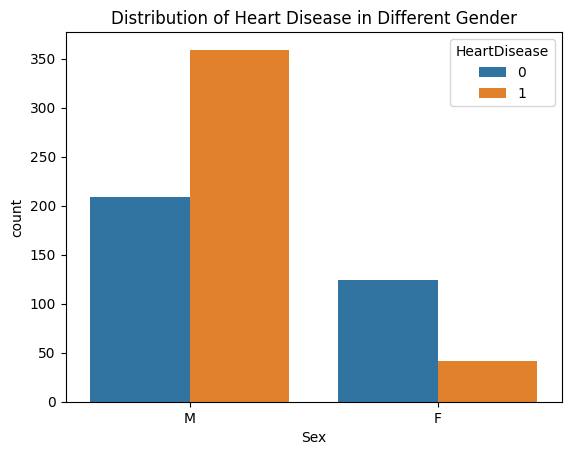

In [89]:
sns.countplot(data=train_set1, x="Sex", hue="HeartDisease")
plt.title("Distribution of Heart Disease in Different Gender")
plt.show()

We can see that our dataset contains more male as compared females. But if we focus on the distribution of heart disease cases, we can see that male has more heart disease cases as compared female. So we can say that males are more prone to heart disease as compared to females.

Let's plot a graph to see how age category is related to both gender and heart disease.

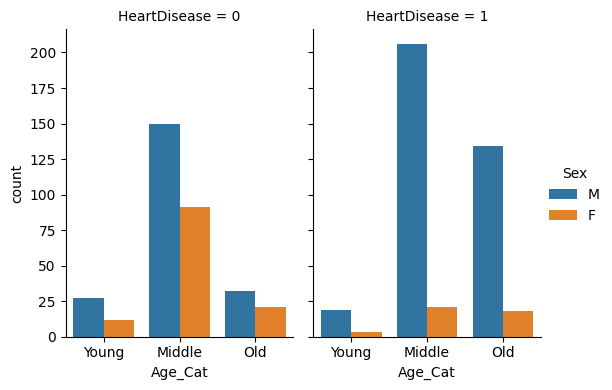

In [90]:
sns.catplot(data=train_set1, x="Age_Cat", hue="Sex", col="HeartDisease", kind="count", height=4, aspect=.7)
plt.show()

The analysis that we did few steps above is confirmed by the combined plot of age categories and its relation to gender and heart disease. We can see that in middle age group males has more heart disease cases as compared to females. Also old men has more heart disease cases as compared to females.

Thus in short: Middle and Old age men are more prone to heart disease but data contains more values for male. So from this point of view, it is unbalanced data.

#### ChestPainType

In [91]:
train_set1["ChestPainType"].value_counts()

ASY    401
NAP    162
ATA    139
TA      32
Name: ChestPainType, dtype: int64

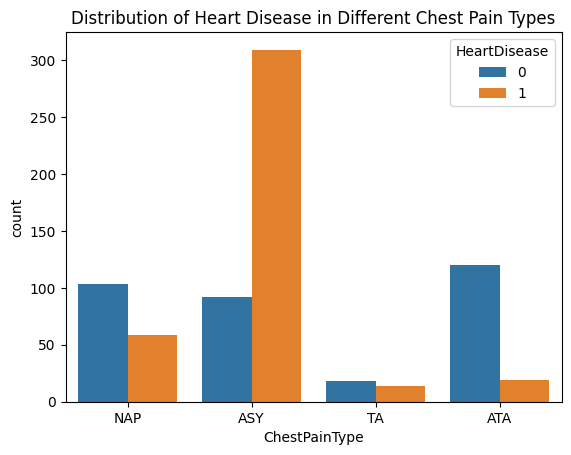

In [92]:
sns.countplot(data=train_set1, x="ChestPainType", hue="HeartDisease")
plt.title("Distribution of Heart Disease in Different Chest Pain Types")
plt.show()

We can see that from all the chest pain types, ASY (Asymptomatic) pain has more cases of heart disease as compared to rest. So we can say that ASY chest pain type is more prone to heart disease. Furthermore, male count is more dataset as compared to females. So it is fair to say that ASY chest pain type is more prone to males and thus making it more prone to heart disease.

#### RestingBP

Though this feature is not much correlated to output variable but still we can see its distribution. Later on we'll try to remove this feature and then train the model again to check whether accuracy is improving or not.

In [93]:
train_set1["RestingBP"].min(), train_set1["RestingBP"].max()

(0, 200)

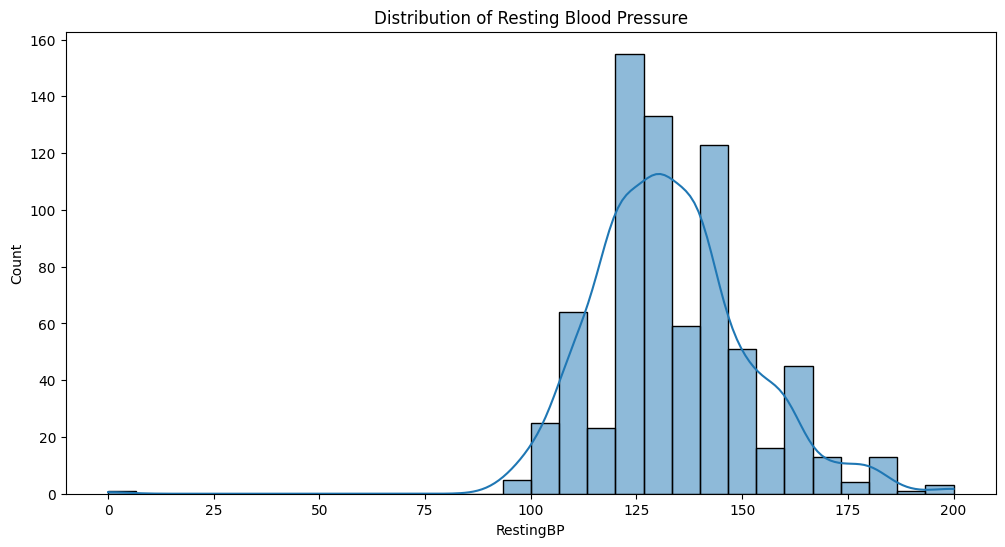

In [94]:
plt.figure(figsize=(12, 6))
sns.histplot(data=train_set1, x="RestingBP", bins=30, kde=True)
plt.title("Distribution of Resting Blood Pressure")
plt.show()

Let's divide the `RestingBP` into following categories:
- 0-80: Low
- 80-120: Normal
- 120-140: Prehypertension
- 140-160: High BP-1
- 160-180: High BP-2
- 180-above: Hypertensive Crisis

In [95]:
train_set1["RestingBP_Cat"] = pd.cut(train_set1["RestingBP"], bins=[0,80, 120, 140, 160, 180, 200], labels=["Low", "Normal", "PreHypertenstion", "High BP-1", "High BP-2", "Hypertensive Crisis"], right=False)

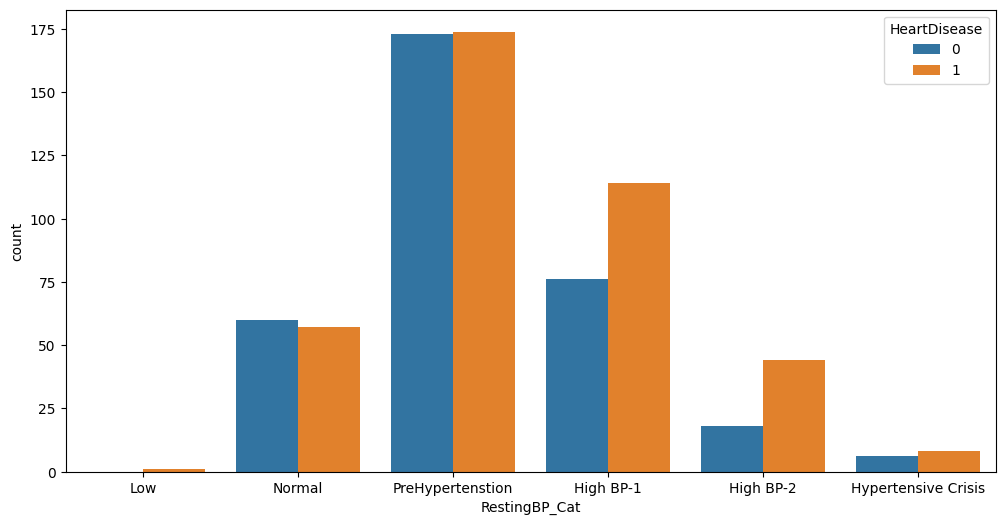

In [96]:
plt.figure(figsize=(12, 6))
sns.countplot(data=train_set1, x="RestingBP_Cat", hue="HeartDisease")
plt.show()

We can say that BP = 0 and BP > 140 are more prone to heart disease though normal BP also has cases of heart diseases. 

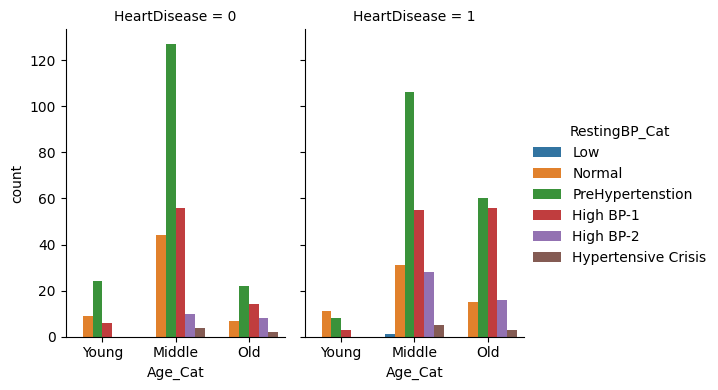

In [97]:
sns.catplot(data=train_set1, x="Age_Cat", hue="RestingBP_Cat", col="HeartDisease", kind="count", height=4, aspect=.7)
plt.show()  

#### Cholesterol

In [98]:
train_set1["Cholesterol"].min(), train_set1["Cholesterol"].max()

(0, 603)

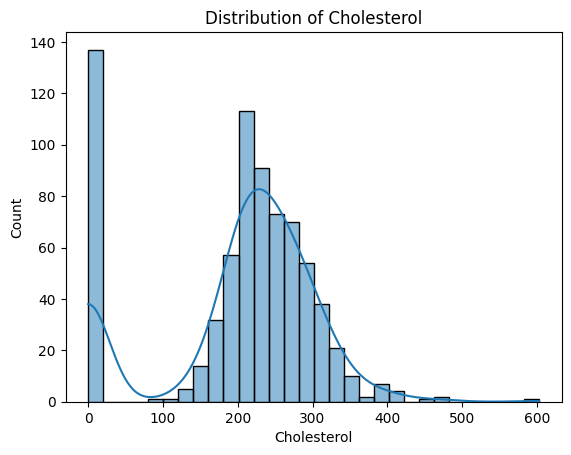

In [99]:
sns.histplot(data=train_set1, x="Cholesterol", bins=30, kde=True)
plt.title("Distribution of Cholesterol")
plt.show()

0 cholesterol is affecting the normal distribution. Suppose if we ignore those 0 values and then check the graph, then we can see that it is normal distribution.

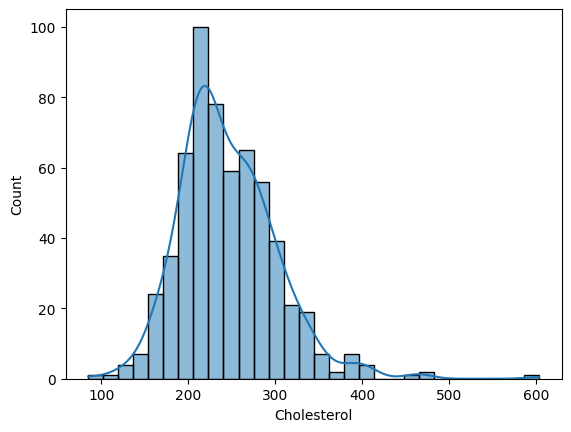

In [100]:
temp = train_set1[train_set1["Cholesterol"] != 0]
sns.histplot(data=temp, x="Cholesterol", bins=30, kde=True)
plt.show()

But hold on, 0 cholesterol doesn't make any sense. It's more like missing values. So instead of removing them we will need to replace them with some appropriate values.

In [101]:
train_set1[train_set1["Cholesterol"] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Age_Cat,RestingBP_Cat
344,51,M,ASY,120,0,1,Normal,104,N,0.0,Flat,1,Middle,PreHypertenstion
398,52,M,ASY,165,0,1,Normal,122,Y,1.0,Up,1,Middle,High BP-2
300,60,M,ASY,160,0,1,Normal,149,N,0.4,Flat,1,Old,High BP-2
326,45,M,NAP,110,0,0,Normal,138,N,-0.1,Up,0,Middle,Normal
430,57,M,ASY,128,0,1,ST,148,Y,1.0,Flat,1,Middle,PreHypertenstion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,63,M,ASY,185,0,0,Normal,98,Y,0.0,Up,1,Old,Hypertensive Crisis
458,61,M,ASY,134,0,1,ST,86,N,1.5,Flat,1,Old,PreHypertenstion
330,60,M,NAP,115,0,1,Normal,143,N,2.4,Up,1,Old,Normal
466,55,M,NAP,120,0,0,ST,125,Y,2.5,Flat,1,Middle,PreHypertenstion


In [102]:
train_set1[train_set1["Cholesterol"] == 0]["HeartDisease"].value_counts()

1    121
0     16
Name: HeartDisease, dtype: int64

There are 137 (121 + 16) rows with 0 cholesterol and out of these 137 rows, 121 rows are having heart disease. So we can't remove these rows. We need to replace these 0 values with some appropriate values.

So how to replace?

Mean and Median won't be a good choice because it might affect the distribution. So what we will do is we will use `K-Neighbours` to predict the missing values and then we will fill them.

##### Imputing the error values in cholesterol with KNN

Let's create seperate dataframe for `cholesterol` to work with. We need to use the whole original dataset to train the model and then predict the missing values. After imputing the missing values, we will again split the dataset into train and test set.

In [103]:
chole_df = df.copy()

In [104]:
chole_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [105]:
chole_df.shape

(918, 12)

We will train model on the data where cholesterol is not 0 and then predict the values where cholesterol is 0. 
So test set will contain all the rows where cholesterol is 0 and train set will contain all the rows where cholesterol is not 0.

In [106]:
chole_train_set = chole_df[chole_df["Cholesterol"] != 0]
chole_test_set = chole_df[chole_df["Cholesterol"] == 0]

In [107]:
chole_train_set.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [108]:
chole_test_set.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1


In [109]:
chole_train_set.shape, chole_test_set.shape

((746, 12), (172, 12))

In [110]:
# remove categorical columns from both train and test sets
cat_cols = chole_train_set.select_dtypes(include=["object"]).columns.values

chole_train_set_num = chole_train_set.drop(cat_cols, axis=1)
chole_test_set_num = chole_test_set.drop(cat_cols, axis=1)

In [111]:
len(cat_cols)

5

In [112]:
chole_train_set_num.shape, chole_test_set_num.shape

((746, 7), (172, 7))

Train features will contain all the columns except `cholesterol` and target will contain `cholesterol`. Here x represents train features and y represents target.

In [113]:
chole_train_set_num_x = chole_train_set_num.drop("Cholesterol", axis=1)
chole_train_set_num_y = chole_train_set_num["Cholesterol"]

chole_train_set_num_x.shape, chole_train_set_num_y.shape

((746, 6), (746,))

Similarly, test features will contain all the columns except `cholesterol` and target will contain `cholesterol`. Here x represents test features and y represents target.

In [114]:
chole_test_set_num_x = chole_test_set_num.drop("Cholesterol", axis=1)
chole_test_set_num_y = chole_test_set_num["Cholesterol"] # this contains only zeros and this is what we want to predict

Now we have our train and test set ready. Let's train the model and predict the missing values. 

But before that we need to scale the data. We will use `StandardScaler` to scale the data.

In [115]:
scaler = StandardScaler()
chole_train_x_scaled = scaler.fit_transform(chole_train_set_num_x)
chole_test_x_scaled = scaler.fit_transform(chole_test_set_num_x)

In [116]:
knn = KNeighborsRegressor()
knn.fit(chole_train_x_scaled, chole_train_set_num_y)

KNeighborsRegressor()

In [117]:
y_pred = knn.predict(chole_test_x_scaled)

In [118]:
y_pred.shape, chole_test_set_num_y.shape

((172,), (172,))

So now these `y_pred` are the predicted values of cholesterol and these values will be used to replace the 0 values in original dataset.

In [119]:
# fill the 0 values of cholesterol with the predicted values
df.loc[df["Cholesterol"] == 0, "Cholesterol"] = np.round(y_pred, 0)

In [120]:
df["Cholesterol"].min(), df["Cholesterol"].max()

(85, 603)

We can see that now minimum value of cholesterol is 85 and maximum value is 603. So we have replaced the 0 values with predicted values.

##### Saving the imputed data

In [121]:
# let's save it to a new csv file
df.to_csv("heart_filled.csv", index=False)

In [122]:
# let's split the data again back to train and test sets
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [123]:
train_set.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
795,42,M,NAP,120,240,1,Normal,194,N,0.8,Down,0
25,36,M,NAP,130,209,0,Normal,178,N,0.0,Up,0
84,56,M,ASY,150,213,1,Normal,125,Y,1.0,Flat,1
10,37,F,NAP,130,211,0,Normal,142,N,0.0,Up,0
344,51,M,ASY,120,239,1,Normal,104,N,0.0,Flat,1


In [124]:
# replace all the columns of the train_set2 with train set except last two columns

train_set2 = pd.concat([train_set, train_set1.iloc[:, -2:]], axis=1)
train_set2.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Age_Cat,RestingBP_Cat
795,42,M,NAP,120,240,1,Normal,194,N,0.8,Down,0,Middle,PreHypertenstion
25,36,M,NAP,130,209,0,Normal,178,N,0.0,Up,0,Young,PreHypertenstion
84,56,M,ASY,150,213,1,Normal,125,Y,1.0,Flat,1,Middle,High BP-1
10,37,F,NAP,130,211,0,Normal,142,N,0.0,Up,0,Young,PreHypertenstion
344,51,M,ASY,120,239,1,Normal,104,N,0.0,Flat,1,Middle,PreHypertenstion


Let's plot the distribution of cholesterol again to see the effect of imputing the missing values.

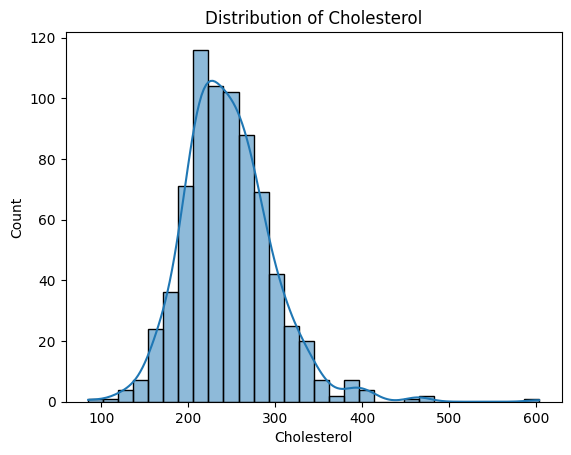

In [125]:
sns.histplot(data=train_set2, x="Cholesterol", bins=30, kde=True)
plt.title("Distribution of Cholesterol")
plt.show()

Let's check it's correlation with output variable.

In [126]:
chol_corr = train_set2.corr(numeric_only=True)
chol_corr["HeartDisease"].sort_values(ascending=False)

HeartDisease    1.000000
Oldpeak         0.422740
Age             0.299410
FastingBS       0.259565
RestingBP       0.138611
Cholesterol     0.089785
MaxHR          -0.414676
Name: HeartDisease, dtype: float64

Earlier when cholesterol was having 0 values, it was negatively correlated to output variable. But now after imputing the missing values, it is positively correlated to output variable. Before it was -0.3 but now it is 0.08. 
Cholesterol should be positively correlated to output variable because as the cholesterol increases the chances of heart disease also increases but it is only 0.08 which is very less. Can we try something more to increase this correlation? 

**Need to figure out**

#### FastingBS

In [127]:
train_set2["FastingBS"].value_counts()

0    567
1    167
Name: FastingBS, dtype: int64

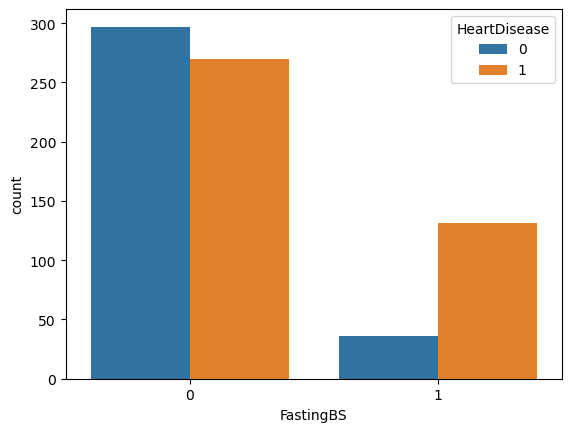

In [77]:
sns.countplot(data=train_set2, x="FastingBS", hue="HeartDisease")
plt.show()

Those who have fasting blood sugar > 120 are more prone to heart disease.

#### RestingECG

In [78]:
train_set2["RestingECG"].value_counts()

Normal    444
LVH       149
ST        141
Name: RestingECG, dtype: int64

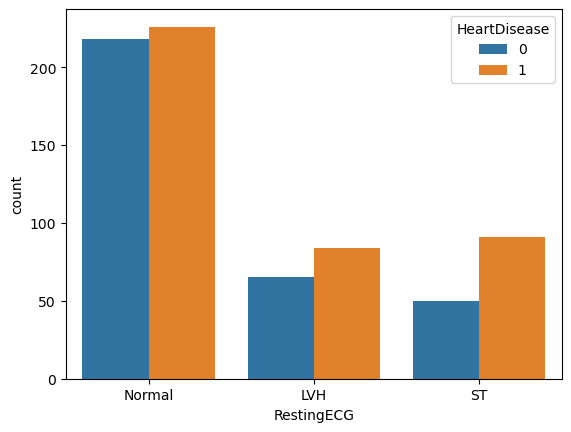

In [79]:
sns.countplot(data=train_set2, x="RestingECG", hue="HeartDisease")
plt.show()

Count of heart patient and normal patient is more in each category. But we can see that ST category has more heart disease cases as compared to other two. In normal and LVH, both heart patient and normal patient count is almost same. So we can't give any general conclusion about these two categories.

/home/dell/anaconda3/envs/latest/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


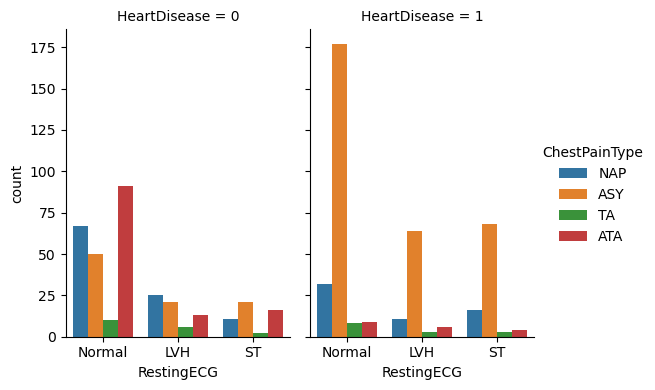

In [80]:
sns.catplot(data=train_set2, x="RestingECG", hue="ChestPainType", col="HeartDisease", kind="count", height=4, aspect=.7)
plt.show()

Normal ECG has more people with asymptomatic chest pain they are more prone to heart disease. But is it because of ECG or chest pain type? We can't say that because we don't have any data to support this.

#### MaxHR

In [81]:
train_set2["MaxHR"].min(), train_set2["MaxHR"].max()

(60, 202)

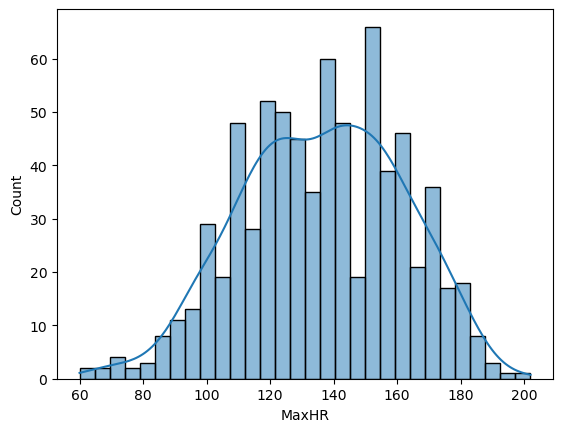

In [82]:
sns.histplot(data=train_set2, x="MaxHR", bins=30, kde=True)
plt.show()

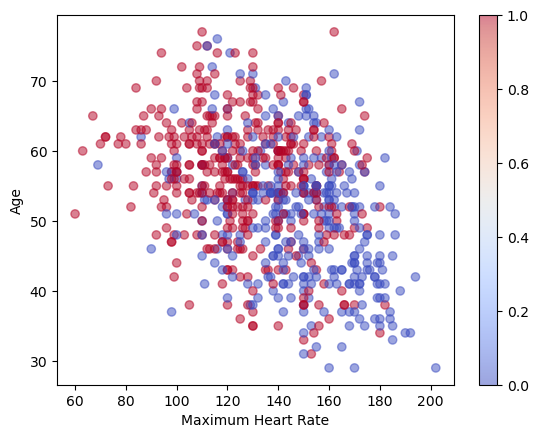

In [83]:
plt.scatter(data=train_set2, x="MaxHR", y="Age", c="HeartDisease", cmap="coolwarm", label="Heart Disease", alpha=0.5)
plt.colorbar()
plt.xlabel("Maximum Heart Rate")
plt.ylabel("Age")
plt.show()

Heart disease patients are of middle age group and they have max heart rate achieved between 150-170. So we can say that people with max heart rate achieved between 60-160 are more prone to heart disease. Above 160, there are very few heart disease cases and younger people are also having max heart rate achieved above 160 (see bottom right portion of the graph).

#### ExerciseAngina

In [84]:
train_set2.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Age_Cat,RestingBP_Cat
795,42,M,NAP,120,240,1,Normal,194,N,0.8,Down,0,Middle,PreHypertenstion
25,36,M,NAP,130,209,0,Normal,178,N,0.0,Up,0,Young,PreHypertenstion
84,56,M,ASY,150,213,1,Normal,125,Y,1.0,Flat,1,Middle,High BP-1
10,37,F,NAP,130,211,0,Normal,142,N,0.0,Up,0,Young,PreHypertenstion
344,51,M,ASY,120,239,1,Normal,104,N,0.0,Flat,1,Middle,PreHypertenstion


In [85]:
train_set2["ExerciseAngina"].value_counts()

N    431
Y    303
Name: ExerciseAngina, dtype: int64

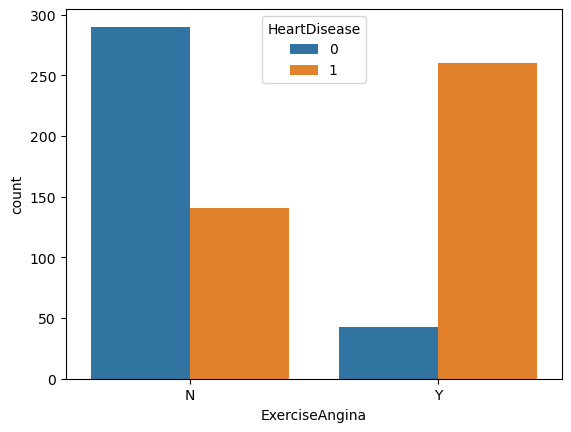

In [86]:
sns.countplot(data=train_set2, x="ExerciseAngina", hue="HeartDisease")
plt.show()

Those who have exercise angina are more prone to heart disease.

#### Oldpeak

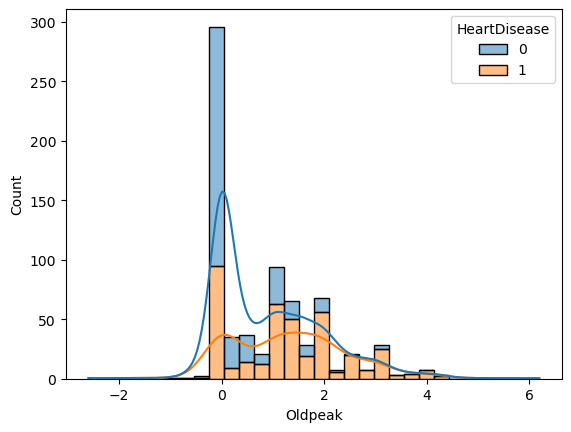

In [87]:
sns.histplot(data=train_set2, x="Oldpeak", bins=30, kde=True, hue="HeartDisease", multiple="stack")
plt.show()

#### ST_Slope

In [88]:
train_set2["ST_Slope"].value_counts()

Flat    379
Up      307
Down     48
Name: ST_Slope, dtype: int64

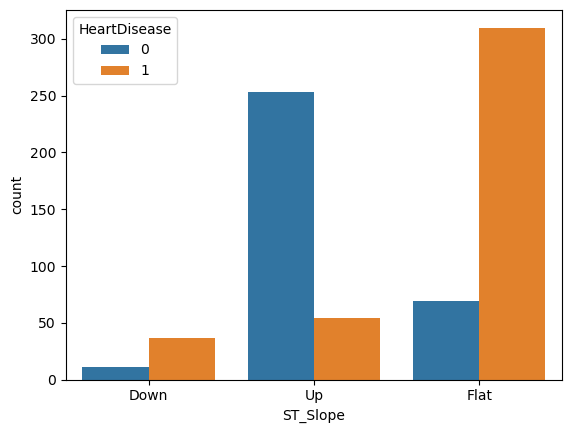

In [89]:
sns.countplot(data=train_set2, x="ST_Slope", hue="HeartDisease")
plt.show()

Down and Flat slope are more prone to heart disease as compared to Up slope.

So we are done with basic EDA. If needed we will revisit this section again. Now let's move to the next section where we will prepare the data and then train the model.

## Preparing data for model

In [4]:
df_final = pd.read_csv('heart_filled.csv')

In [5]:
train_set_final, test_set_final = train_test_split(df_final, test_size=0.2, random_state=42)

In [6]:
train_set_final.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
795,42,M,NAP,120,240,1,Normal,194,N,0.8,Down,0
25,36,M,NAP,130,209,0,Normal,178,N,0.0,Up,0
84,56,M,ASY,150,213,1,Normal,125,Y,1.0,Flat,1
10,37,F,NAP,130,211,0,Normal,142,N,0.0,Up,0
344,51,M,ASY,120,239,1,Normal,104,N,0.0,Flat,1


In [7]:
train_set_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 734 entries, 795 to 102
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             734 non-null    int64  
 1   Sex             734 non-null    object 
 2   ChestPainType   734 non-null    object 
 3   RestingBP       734 non-null    int64  
 4   Cholesterol     734 non-null    int64  
 5   FastingBS       734 non-null    int64  
 6   RestingECG      734 non-null    object 
 7   MaxHR           734 non-null    int64  
 8   ExerciseAngina  734 non-null    object 
 9   Oldpeak         734 non-null    float64
 10  ST_Slope        734 non-null    object 
 11  HeartDisease    734 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 74.5+ KB


### Seperating Features and Labels

In [8]:
heart_features = train_set_final.drop("HeartDisease", axis=1)
heart_labels = train_set_final["HeartDisease"]

In [85]:
X_test = test_set_final.drop("HeartDisease", axis=1)
y_test = test_set_final["HeartDisease"]

We'll need validation set to also check the performance of our model. So we will further split the data into train and validation set.

In [62]:
heart_features.shape, heart_labels.shape

((734, 11), (734,))

In [65]:
X_train, X_val, y_train, y_val = train_test_split(heart_features, heart_labels, test_size=0.15, random_state=42)

In [66]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((623, 11), (111, 11), (623,), (111,))

In [67]:
X_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
831,63,F,NAP,135,252,0,LVH,172,N,0.0,Up
776,62,F,ASY,150,244,0,Normal,154,Y,1.4,Flat
644,71,F,NAP,110,265,1,LVH,130,N,0.0,Up
571,69,M,ASY,140,110,1,Normal,109,Y,1.5,Flat
341,64,M,ASY,110,289,1,Normal,114,Y,1.3,Down


In [68]:
y_train.head()

831    0
776    1
644    0
571    1
341    1
Name: HeartDisease, dtype: int64

### Handling Categorical Data

In [69]:
heart_features_1 = X_train.copy()

In [70]:
heart_features_1.select_dtypes("object")

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
831,F,NAP,LVH,N,Up
776,F,ASY,Normal,Y,Flat
644,F,NAP,LVH,N,Up
571,M,ASY,Normal,Y,Flat
341,M,ASY,Normal,Y,Down
...,...,...,...,...,...
456,M,NAP,Normal,Y,Flat
893,M,ATA,LVH,N,Up
153,M,ASY,Normal,N,Up
53,F,ATA,Normal,N,Up


In [71]:
cat_heart_features = heart_features_1.select_dtypes("object").columns.values
cat_heart_features

array(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'],
      dtype=object)

In [72]:
cat_features_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded_attr = cat_features_encoder.fit_transform(heart_features_1[cat_heart_features])

In [73]:
one_hot_encoded_attr

array([[1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.]])

In [74]:
one_hot_encoded_attr.shape

(623, 14)

In [76]:
cat_features_encoder.categories_

[array(['F', 'M'], dtype=object),
 array(['ASY', 'ATA', 'NAP', 'TA'], dtype=object),
 array(['LVH', 'Normal', 'ST'], dtype=object),
 array(['N', 'Y'], dtype=object),
 array(['Down', 'Flat', 'Up'], dtype=object)]

In [77]:
cat_features_encoder.get_feature_names_out(cat_heart_features) # returns the column names of the one hot encoded attributes

array(['Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA',
       'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH',
       'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_N',
       'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat',
       'ST_Slope_Up'], dtype=object)

In [78]:
# now we have one hot encoded data , we can convert it to df, and then we will concatenate it with the numerical data
col_names = cat_features_encoder.get_feature_names_out(cat_heart_features)
one_hot_encoded_df = pd.DataFrame(one_hot_encoded_attr, columns=col_names)
one_hot_encoded_df.head()

,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


In [79]:
num_heart_features = heart_features_1.select_dtypes("number")
num_heart_features.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
831,63,135,252,0,172,0.0
776,62,150,244,0,154,1.4
644,71,110,265,1,130,0.0
571,69,140,110,1,109,1.5
341,64,110,289,1,114,1.3


In [80]:
std_scaler = StandardScaler()
num_heart_features_scaled = std_scaler.fit_transform(num_heart_features)
num_heart_features_scaled

array([[ 0.97167831,  0.12829909,  0.10255893, -0.53341924,  1.40415236,
        -0.84209531],
       [ 0.86612372,  0.94114996, -0.05486445, -0.53341924,  0.70363788,
         0.46062823],
       [ 1.81611506, -1.22645235,  0.35837191,  1.87469804, -0.23038144,
        -0.84209531],
       ...,
       [ 0.12724157, -0.68455177,  0.45676151, -0.53341924,  0.15879328,
        -0.84209531],
       [-1.35052273, -0.1426512 , -0.03518652, -0.53341924,  0.54796799,
        -0.84209531],
       [ 0.54945994,  2.02495111,  0.8109641 , -0.53341924,  0.89822523,
        -0.65599195]])

In [81]:
num_heart_features_scaled_df = pd.DataFrame(num_heart_features_scaled, columns=num_heart_features.columns)
num_heart_features_scaled_df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
0,0.971678,0.128299,0.102559,-0.533419,1.404152,-0.842095
1,0.866124,0.941150,-0.054864,-0.533419,0.703638,0.460628
2,1.816115,-1.226452,0.358372,1.874698,-0.230381,-0.842095
3,1.605006,0.399249,-2.691706,1.874698,-1.047648,0.553680
4,1.077233,-1.226452,0.830642,1.874698,-0.853061,0.367577


In [82]:
num_heart_features_scaled_df.shape, one_hot_encoded_df.shape

((623, 6), (623, 14))

Number of rows for both are same, so we can concatenate them easily.

In [83]:
heart_features_final = pd.concat([num_heart_features_scaled_df, one_hot_encoded_df], axis=1)
heart_features_final.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,0.971678,0.128299,0.102559,-0.533419,1.404152,-0.842095,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.866124,0.941150,-0.054864,-0.533419,0.703638,0.460628,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.816115,-1.226452,0.358372,1.874698,-0.230381,-0.842095,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.605006,0.399249,-2.691706,1.874698,-1.047648,0.553680,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.077233,-1.226452,0.830642,1.874698,-0.853061,0.367577,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


In [84]:
heart_features_final.shape

(623, 20)

Whenever new data will arrive it will contain categorical features as well as numerical data. Thus before feeding it to model we need to encode it. We will also need to scale the numerical data. We already did this all for training data. So we will use the same `OneHotEncoder` and `StandardScaler` to transform this new input. But instead of performing these steps again and again, we can create a pipeline and then use it to transform the new input. It will streamline the process. 

## Pipeline

### Dummy data for testing pipeline

In [86]:
testing_pipline_data = X_test.copy()
testing_pipline_data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
668,63,F,ATA,140,195,0,Normal,179,N,0.0,Up
30,53,M,NAP,145,518,0,Normal,130,N,0.0,Flat
377,65,M,ASY,160,234,1,ST,122,N,1.2,Flat
535,56,M,ASY,130,275,0,LVH,122,Y,1.0,Flat
807,54,M,ATA,108,309,0,Normal,156,N,0.0,Up


In [87]:
# Pipeline for numerical data
num_pipline = Pipeline([
    ("std-scaler", StandardScaler())
])

In [88]:
testing_num_features_tr = num_pipline.fit_transform(testing_pipline_data.select_dtypes("number"))
testing_num_features_tr

array([[ 1.03813138,  0.55273687, -0.71523836, -0.5857181 ,  1.53637764,
        -0.82051766],
       [ 0.0050531 ,  0.82193641,  4.29513953, -0.5857181 , -0.36115398,
        -0.82051766],
       [ 1.24474703,  1.62953502, -0.11027013,  1.70730595, -0.67095506,
         0.38487355],
       ...,
       [ 1.14143921,  0.60657678,  0.04484993,  1.70730595, -0.90330586,
         0.68622135],
       [-0.40817821,  0.0143378 ,  0.38611406, -0.5857181 ,  1.22657656,
        -0.21782205],
       [ 1.14143921,  0.7680965 ,  0.57225813, -0.5857181 , -0.67095506,
         0.18397502]])

`num_pipeline` working fine. Now we will create a pipeline for categorical columns. 

In [89]:
cat_pipeline = Pipeline([
    ("encoder", OneHotEncoder(sparse_output=False))
])

Let's test the `cat_pipeline` on categorical columns.

In [90]:
testing_cat_features_tr = cat_pipeline.fit_transform(testing_pipline_data.select_dtypes("object"))
testing_cat_features_tr

array([[1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 1., 0.],
       ...,
       [0., 1., 1., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 1., 0.]])

We will feed the whole data to the pipeline as it is. So it is the task of the pipeline to select the numerical features and categorical features and apply the appropriate pipeline. Thus for selecting the appropriate data we will create `DataFrameSelector` class. It will return the data based on the attributes.

In [91]:

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attributes_names):
        self.attributes_names = attributes_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attributes_names]

In [92]:
num_attr = heart_features_1.select_dtypes("number").columns.values
cat_attr = heart_features_1.select_dtypes("object").columns.values

In [93]:
num_pipeline = Pipeline([
    ("selector", DataFrameSelector(num_attr)), # first select numerical attributes
    ("std_scaler", StandardScaler()) # then scale them
])

cat_pipeline = Pipeline([
    ("selector", DataFrameSelector(cat_attr)), # select categorical attributes
    ("encoder", OneHotEncoder(sparse_output=False)) # then one hot encode them
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

In [94]:
testing_pipeline_full_tr = full_pipeline.fit_transform(heart_features_1)

In [95]:
testing_pipeline_full_tr.shape

(623, 20)

In [96]:
heart_features_final.shape

(623, 20)

Our pipeline is working fine. We can cross check from the shape of that array (`heart_features_final`) that we created manually. It should be same as the shape of the array that we got from the pipeline.

Let's transform the whole data using the pipeline.

In [101]:
X_train_tr= full_pipeline.fit_transform(heart_features_1)
X_train_tr.shape

(623, 20)

In [98]:
X_val_tr = full_pipeline.fit_transform(X_val)
X_val_tr.shape

(111, 20)

## Model Training

### 1. Logistic Regression

In [102]:
lr = LogisticRegression()
lr.fit(X_train_tr, y_train)

LogisticRegression()

#### Predictions

##### Predicting an instance

In [103]:
new = X_test.iloc[:1]
new 

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
668,63,F,ATA,140,195,0,Normal,179,N,0.0,Up


In [104]:
new_tr = full_pipeline.transform(new)
new_tr

array([[ 0.97167831,  0.39924938, -1.0190826 , -0.53341924,  1.67657466,
        -0.84209531,  1.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  1.        ]])

In [105]:
lr.predict(new_tr)

array([0])

The model says that the person is not having heart disease. Let's check the actual value.

In [106]:
y_test.iloc[:1]

668    0
Name: HeartDisease, dtype: int64

Indeed the person is not having heart disease. So the model is predicting correctly.

##### Predicting for all instances

In [109]:
X_test_tr = full_pipeline.transform(X_test)
y_pred = lr.predict(X_test_tr)

In [110]:
X_test_tr.shape, y_pred.shape

((184, 20), (184,))

#### Performance Evaluation

##### Accuracy

In [111]:
score = lr.score(X_test_tr, y_test)
print(score)

0.8695652173913043


Logistic Regression is giving around 86% accuracy.

##### Confusion Matrix

In [112]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[68,  9],
       [15, 92]])

Understanding the confusion matrix:

- True Positive (TP): The number of correct predictions that an instance is positive.
- True Negative (TN): The number of correct predictions that an instance is negative.
- False Positive (FP): The number of those instances which our model wrongly classified as positive. In other words, the number of those instances which are actually negative but our model classified them as positive.
- False Negative (FN): The number of those instances which our model wrongly classified as negative. In other words, the number of those instances which are actually positive but our model classified them as negative.

Let's plot the confusion matrix to get a better understanding

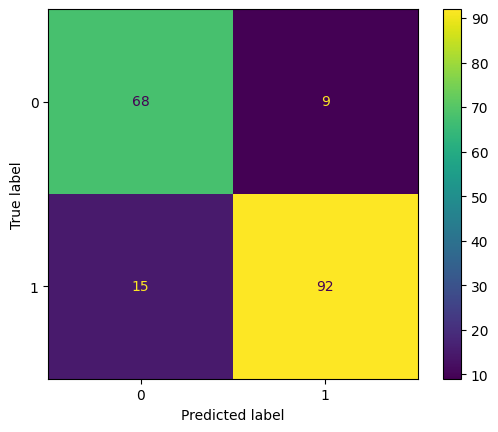

In [113]:
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

In dataset "0" means patient is not having heart disease thus we are considering it as negative and "1" means patient is having heart disease thus we are considering it as positive.

So we can see that, 68 instances are correctly classified as true negative and 92 instances are correctly classified as true positive. 15 instances are wrongly classified as false negative and 9 instances are wrongly classified as false positive.

##### Precision and Recall

In [114]:
precision_score(y_test, y_pred)

0.9108910891089109

Precision give the accuracy of the positive predictions. It is the ratio of correctly predicted positive observations to the total predicted positives. The question that this metric answer is of all the people that model predicted as having heart disease, how many actually have heart disease?

In [115]:
recall_score(y_test, y_pred)

0.8598130841121495

Recall calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive). It is the ratio of correctly predicted positive observations to the all observations in actual class. The question recall answers is: Of all the people that have heart disease, how many did the model correctly predict?

##### F1 Score

In [116]:
f1_score(y_test, y_pred)

0.8846153846153846

##### ROC Curve

In [117]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

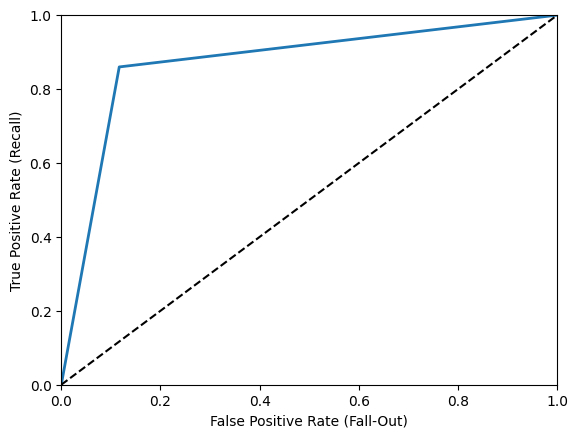

In [118]:
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], "k--")
plt.axis([0,1,0,1])
plt.xlabel("False Positive Rate (Fall-Out)")
plt.ylabel("True Positive Rate (Recall)")
plt.show()

In [119]:
roc_auc_score(y_test, y_pred)

0.8714649836145163

**TODO:**

Need to finalize which metrics to use for evaluation. Need to decide from roc curve, PR curve, plus others (if any)

### 2. Neural Network

In [123]:
model = keras.models.Sequential([
    keras.layers.Input(shape=[heart_features_final.shape[1]]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("nn_models/heart_model_1.keras", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard("logs/heart_model_1")


h = model.fit(X_train_tr, y_train, epochs=100, validation_data=(X_val_tr, y_val), 
            callbacks=[early_stopping_cb, model_checkpoint_cb, tensorboard_cb])

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4811 - loss: 0.7279 - val_accuracy: 0.7838 - val_loss: 0.6169
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7231 - loss: 0.6224 - val_accuracy: 0.8829 - val_loss: 0.5355
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8228 - loss: 0.5384 - val_accuracy: 0.9009 - val_loss: 0.4761
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8249 - loss: 0.4977 - val_accuracy: 0.9009 - val_loss: 0.4268
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8359 - loss: 0.4575 - val_accuracy: 0.9099 - val_loss: 0.3859
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8414 - loss: 0.4311 - val_accuracy: 0.9189 - val_loss: 0.3552
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8410 - loss: 0.4111 - val_accuracy: 0.9189 - val_loss: 0.3342
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8413 - loss: 0.3903 - val_accuracy: 0.9189 - 

In [124]:
test_loss, test_accuracy = model.evaluate(X_test_tr, y_test)

print(f"Test accuracy: {test_accuracy * 100:.2f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8490 - loss: 0.3490 
Test accuracy: 85.33


In [2]:
model = keras.models.load_model("nn_models/heart_model_1.keras")

In [ ]:
cm = confusion_matrix(y_test, model.predict_classes(X_test_tr))

another model

In [125]:
keras.backend.clear_session()

model = keras.models.Sequential([
    keras.layers.Input(shape=[heart_features_final.shape[1]]),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("nn_models/heart_model_2.keras", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard("logs/heart_model_2")


h = model.fit(X_train_tr, y_train, epochs=100, validation_data=(X_val_tr, y_val), 
            callbacks=[early_stopping_cb, model_checkpoint_cb, tensorboard_cb])

Epoch 1/100


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5809 - loss: 0.6777 - val_accuracy: 0.8559 - val_loss: 0.5233
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7916 - loss: 0.5172 - val_accuracy: 0.8739 - val_loss: 0.4151
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8212 - loss: 0.4434 - val_accuracy: 0.8919 - val_loss: 0.3373
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8345 - loss: 0.4402 - val_accuracy: 0.9099 - val_loss: 0.3133
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8418 - loss: 0.3927 - val_accuracy: 0.9009 - val_loss: 0.3016
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8726 - loss: 0.3588 - val_accuracy: 0.8919 - val_loss: 0.2921
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8568 - loss: 0.3602 - val_accuracy: 0.9189 - val_loss: 0.2960
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8488 - loss: 0.3974 - val_accuracy: 0.9099 - val_loss: 0.

In [127]:
test_loss, test_accuracy = model.evaluate(X_test_tr, y_test)

print(f"Test accuracy: {test_accuracy * 100:.2f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8182 - loss: 0.3920 
Test accuracy: 83.70
